In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel('https://community.tableau.com/servlet/JiveServlet/downloadBody/1236-102-2-15278/Sample%20-%20Superstore.xls')

In [16]:
# The loc[] means furniture will be the a slice of rows, where each row has their ['Category'] column
# equal to furniture. 
# So, rows of furniture
furniture = df.loc[df['Category'] == 'Furniture']

In [17]:
# We don't need these rows.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
# Order date is still a column, but it's sorted on it. NOT THE INDEX YET.
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [18]:
#Instead of using .sample, we just .groupby the ['Order Date'] column, which would keep them at the day level of 
#time sampling
#Each day is getting the sum of each sales smushed into the dates in this groupby object.
#The index is reset to 0-n along this groupby object.
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [19]:
#Now the Medium blog wants to set the index with the time column.
furniture = furniture.set_index('Order Date')
len(furniture.index)

889

In [21]:
#I'm assuming the y means this will be a target variable to evaluate predictions against.
#Either way, it is the daily furniture sales resampled at a monthly rate, smushing together with 'mean'.
#The S in MS means at the start of the month, not the 28th, 30th or 31st.
y = furniture['Sales'].resample('MS').mean()

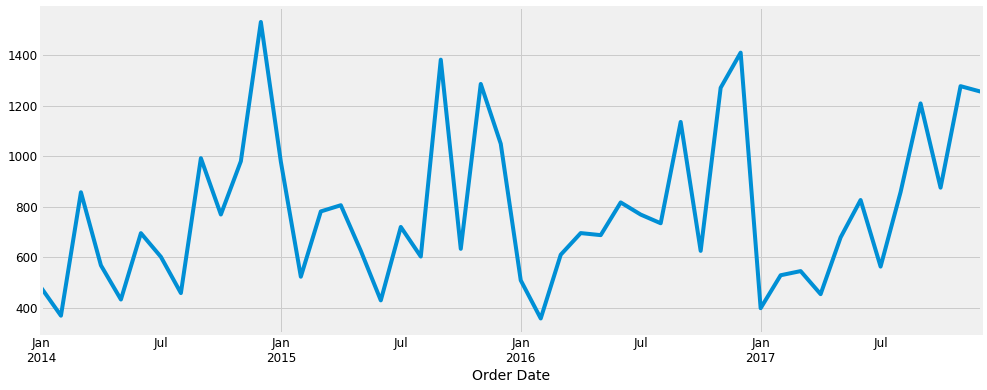

In [24]:
#This is a basic time plot of the monthly average of furniture sales from 2014-2017
y.plot(figsize=(15, 6))
plt.show()

    Looks like a clear seasonal pattern cycled every calender year.

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

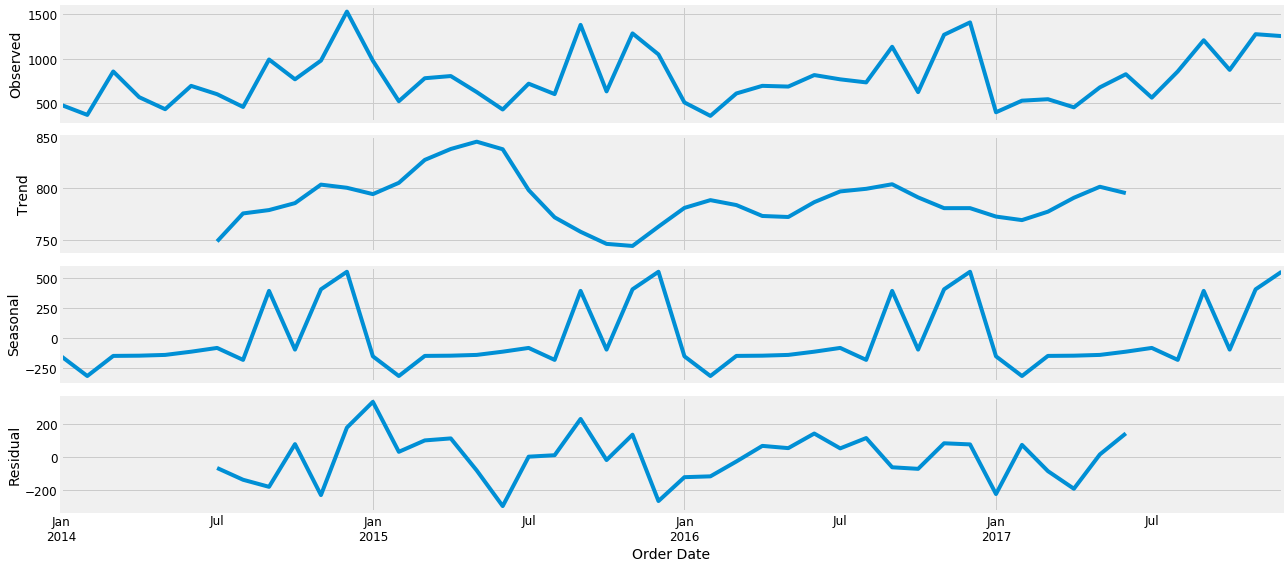

In [27]:
#Using this method from the statsmodel module, we can cut up this timeline into its systematic components.
#Observed : Level 
#Trend : Trend
#Seasonal : Seasonality
#Residual : Noise/Error
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Forecasting

ARIMA models are denoted with the notation ARIMA(p, d, q)

    p = seasonality,  d = trend, q = noise

In [ ]:
p = d = q = range(0, 2)
#PDQ is a list of tuples, that is cartesian product of (p, d, q), each of which is [0,1]. 
#So i guess that makes a 2^3 amount of tuples that are every possible permutation of 0/1 in 3 spaces.
pdq = list(itertools.product(p, d, q))

In [28]:
#HOly crap. That is some heavy pythonic language. 
#So it's a list comprehension! iterator FOR iterator IN iterable!
#iterator = (x[0], x[1], x[2], 12)
#    this tuple of 4 will each get filled by the 3 values in each iteration. 12 gets appended as the last value.
#iterable is that list of tuples that is each permutation of 0/1 in 3 spaces
#This makes a list of tuples. Same as PDQ, but with in the last spot of each tuple. ...Dunno, why?
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## parameter Selection for our furniture’s sales ARIMA Time Series Model

In [ ]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
# results = mod.fit()
# print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. 

Therefore we should consider this to be optimal option.

So that'll be the parameters in the 1st step of Model,Fit,Predict API.

# Fitting the ARIMA model


In [49]:
mod = sm.tsa.statespace.SARIMAX(y,
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 0, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


In [52]:
#THIS IS A FOREIGN OBJECT TO ME. I dont know any of its attributes or methods.
#I would guess you can't call a sm.timeseriesanalyis model without giving it some data. 
#So a semi-fitted stat model
type(mod)

statsmodels.tsa.statespace.sarimax.SARIMAX

In [51]:
#THIS IS A FOREIGN OBJECT TO ME. I dont know any of its attributes or methods.
#Results is a full blown post-step2 fitted stats model. 
#Its also a wrapper of the previous object
type(results)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

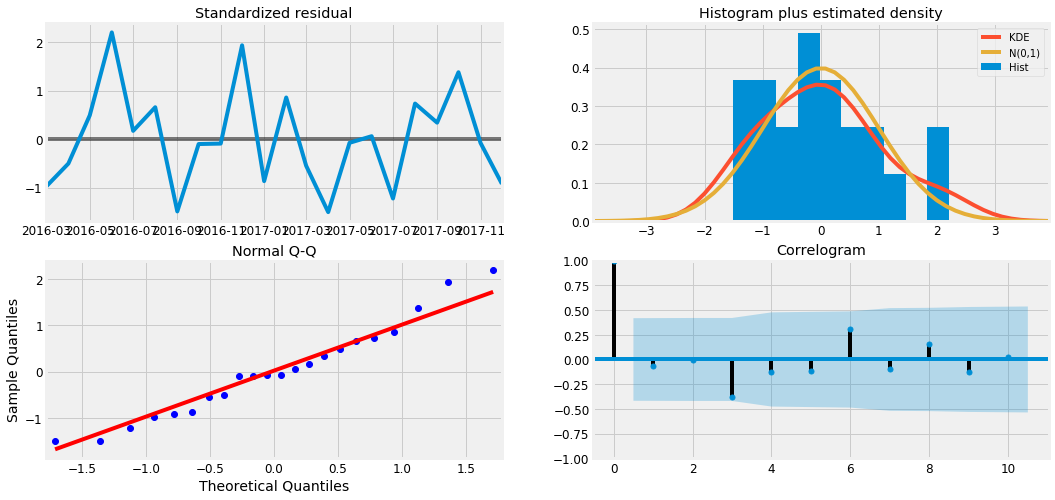

In [50]:
#Boy I should look at this plot_diagnostic function. Seems handy.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
#SHIT GETS SUPER COMPLICATED

#Looks like that fitted tsa model has a get_predictions method.
#We give a start parameter that is a timestamp. 
#Pred is the predictions for the index slice above the timestamp 2017-01-01, 
#    derived from mod -> results -> pred, which has a confidence interval 
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)

In [54]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [ ]:
#That pred is another wrapper.
#That pred, which is wrapper of a wrapper of the tsa model, has a confidence interval method.
pred_ci = pred.conf_int()

In [55]:
#Look at that. A good ol' fashioned DataFrame
type(pred_ci)

pandas.core.frame.DataFrame

In [62]:
#OH. It's a confidence interval. Lower and upper bounds.
pred_ci

,lower Sales,upper Sales
Order Date,,
2017-01-01,204.675905,895.517792
2017-02-01,31.859878,721.913177
2017-03-01,296.215951,985.551782
2017-04-01,373.138250,1061.818526
2017-05-01,347.351784,1035.430734
2017-06-01,471.969384,1159.494776
2017-07-01,433.445516,1120.459641
2017-08-01,385.912602,1072.453084
2017-09-01,806.828483,1492.928941


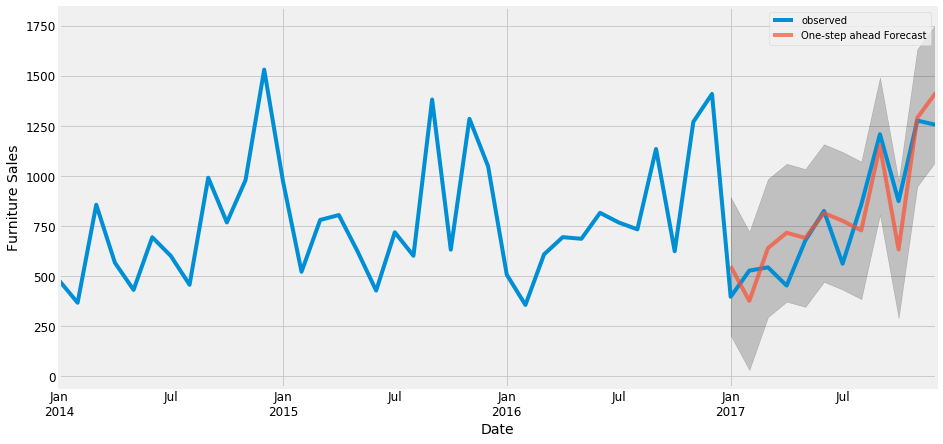

In [53]:
#This stuff looks to be careful plotting to show visually what the conifdence interval looks like 
ax = y['2014':].plot(label='observed')
#pred object has a predicted mean method. It is plotted alongside the entire dataset
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#Makes that hazy broad bar illustratig the lower bounds: pred_ci.iloc[:, 0]   upper bounds: pred_ci.iloc[:, 1]
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

#### COLD HARD NUMBERS INSTEAD OF A GRAPH

In [ ]:
#This is the prediction. 12 months, each with a predicted value.
y_forecasted = pred.predicted_mean

In [ ]:
#The actual values. 12 of them
y_truth = y['2017-01-01':]

In [58]:
#Make the mean squared error by getting the squared value of each of the 12 differences
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [63]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


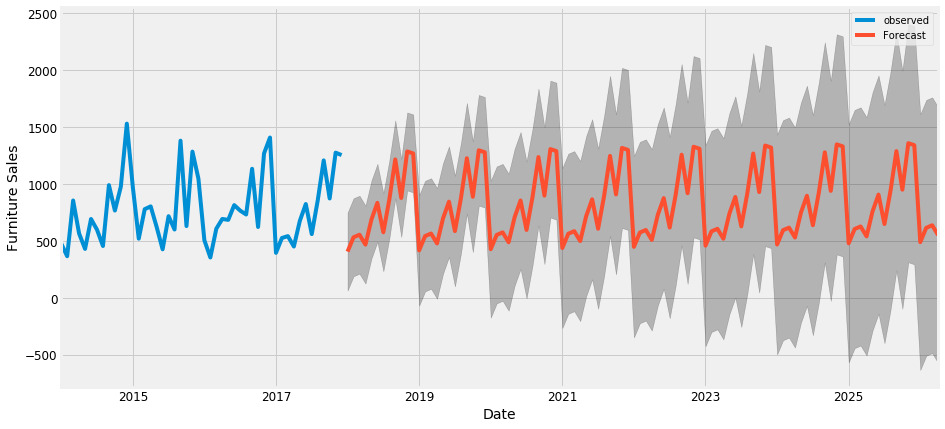

In [64]:
#We'll look another day. But this is a plot to show waht the next few cycles will be predicted to look.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()